# deskripsi library yg digunakan

In [1]:
import pandas as pd
import numpy as np

# library untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# library untuk analisis time series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# library untuk algoritma forecasting
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# memanggin dataset

In [2]:
df = pd.read_excel('CO2 dataset.xlsx')

# deskripsi dataset

In [3]:
df.head()

,Year,CO2
0,1800,0.00568
1,1801,0.00561
2,1802,0.00555
3,1803,0.00548
4,1804,0.00542


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    215 non-null    int64  
 1   CO2     215 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.5 KB


In [5]:
df.duplicated().sum()

0

# transform data

In [6]:
df['Year'] = pd.to_datetime(df['Year'], format='%Y') # mengubah kolom tahun ke dalam datetime

In [7]:
df.set_index(['Year'], inplace=True) # mengubah index menjadi datetime 

In [8]:
df.head()

,CO2
Year,
1800-01-01,0.00568
1801-01-01,0.00561
1802-01-01,0.00555
1803-01-01,0.00548
1804-01-01,0.00542


In [9]:
df.index.min(), df.index.max()

(Timestamp('1800-01-01 00:00:00'), Timestamp('2014-01-01 00:00:00'))

In [10]:
# cek jika data bersifat continues
if (df.index.max() - df.index.min() == 214): 
    print('Data Is Continuous')

In [11]:
df.index.freq='YS' # setting data frequency to year

# analisa time series

<AxesSubplot:xlabel='Year'>

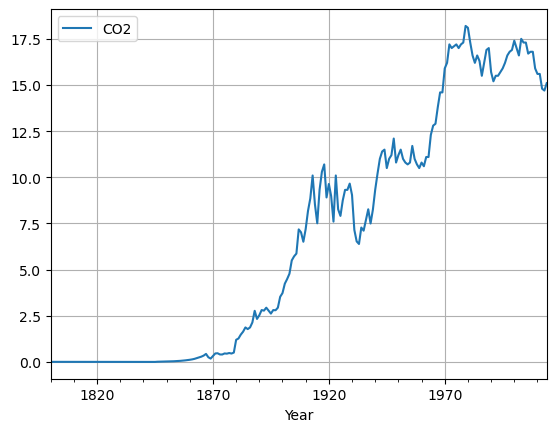

In [12]:
df.plot(grid=True)

In [13]:
train_df = df.loc[:'1991-01-01']
test_df = df.loc['1992-01-01':]

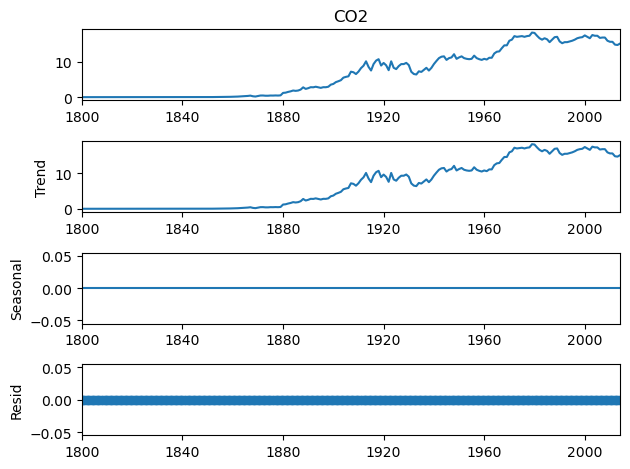

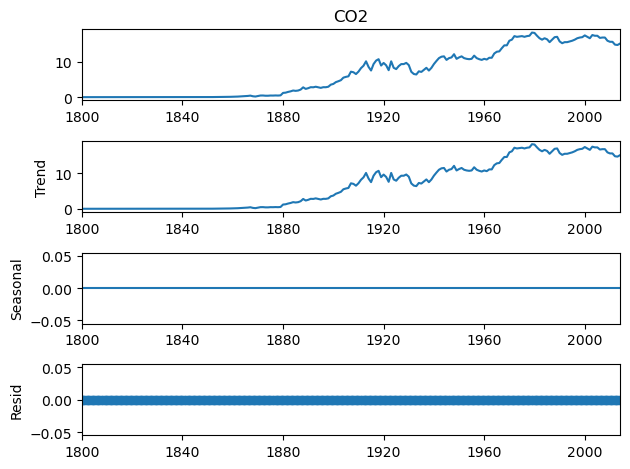

In [14]:
decompose_add = seasonal_decompose(df['CO2'])
decompose_add.plot()

In [15]:
# functon for adf test
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    print ('----------------------------------------------')
    adftest = adfuller(timeseries)
    adf_output = pd.Series(adftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in adftest[4].items():
        adf_output['Critical Value (%s)'%key] = value
    print (adf_output)
    
# calling adf function and passing series
adf_test(df.values)

Results of Dickey-Fuller Test:
----------------------------------------------
Test Statistic                  -0.378463
p-value                          0.913633
#Lags Used                       0.000000
Number of Observations Used    214.000000
Critical Value (1%)             -3.461282
Critical Value (5%)             -2.875143
Critical Value (10%)            -2.574020
dtype: float64


In [16]:
diff_df = df.diff() #first differencing for stationarity
diff_df.head()

,CO2
Year,
1800-01-01,NaN
1801-01-01,-0.00007
1802-01-01,-0.00006
1803-01-01,-0.00007
1804-01-01,-0.00006


In [17]:
diff_df.dropna(inplace=True) # depending on your differenced order you might have 1,2 or 3 null values, remove those

<AxesSubplot:xlabel='Year'>

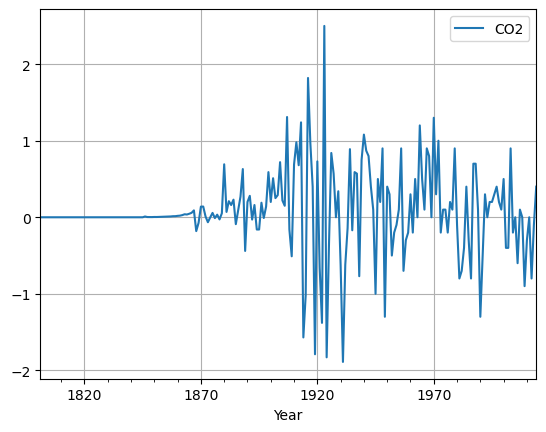

In [18]:
diff_df.plot(grid=True)

In [19]:
# call the adf_test function and pass differenced series
adf_test(diff_df)

Results of Dickey-Fuller Test:
----------------------------------------------
Test Statistic                  -3.780005
p-value                          0.003119
#Lags Used                      15.000000
Number of Observations Used    198.000000
Critical Value (1%)             -3.463815
Critical Value (5%)             -2.876251
Critical Value (10%)            -2.574611
dtype: float64


c:\Users\PRODI-TIF\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


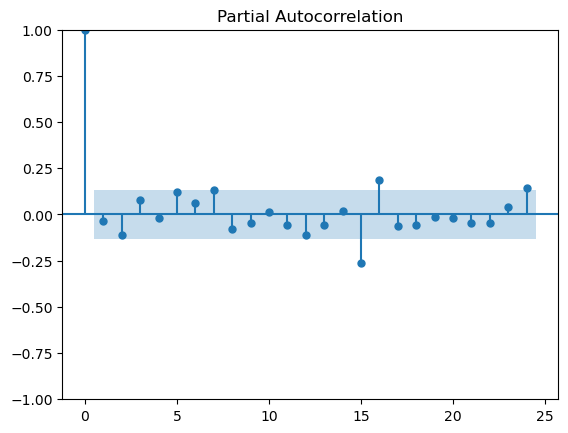

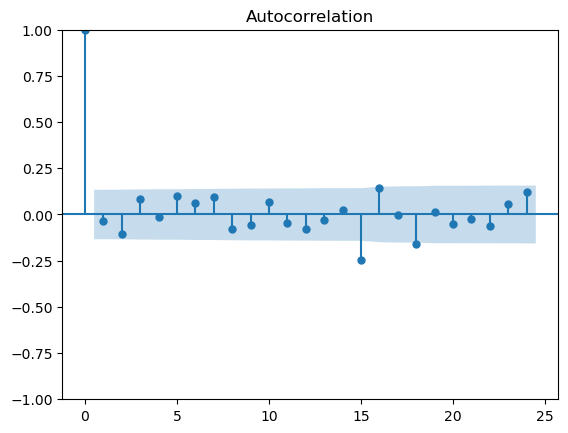

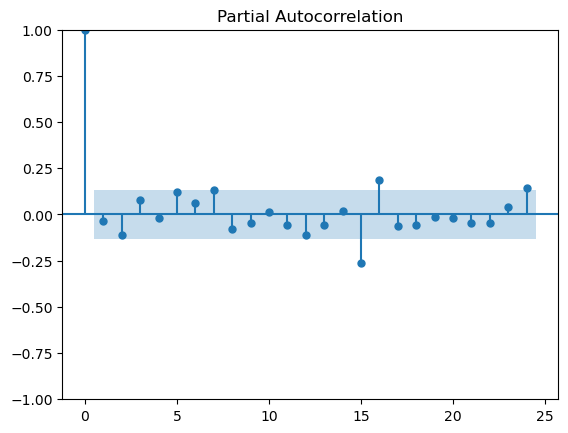

In [20]:
# if the series is not stationary then make sure to pass differenced series instead of original series
plot_acf(diff_df)
plot_pacf(diff_df)

# Single Exponential Smoothing

In [21]:
single_exp = SimpleExpSmoothing(train_df).fit()
single_exp_train_pred = single_exp.fittedvalues
single_exp_test_pred = single_exp.forecast(23)

<AxesSubplot:xlabel='Year'>

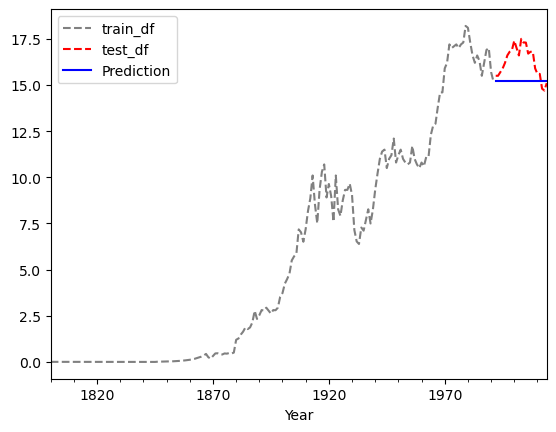

In [22]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['CO2'].plot(style='--', color='r', legend=True, label='test_df')
single_exp_test_pred.plot(color='b', legend=True, label='Prediction')

In [23]:
print('Train RMSE:',mean_squared_error(train_df, single_exp_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df, single_exp_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df, single_exp_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df, single_exp_test_pred))

Train RMSE: 0.5646920026799559
Test RMSE: 1.342911299570218
Train MAPE: 0.08470516095927101
Test MAPE: 0.06861466396961562


# Double Exponential Smoothing

In [24]:
double_exp = ExponentialSmoothing(train_df, trend=None, initialization_method='heuristic', seasonal='add', seasonal_periods=29, damped_trend=False).fit()
double_exp_train_pred = double_exp.fittedvalues
double_exp_test_pred = double_exp.forecast(23)

<AxesSubplot:xlabel='Year'>

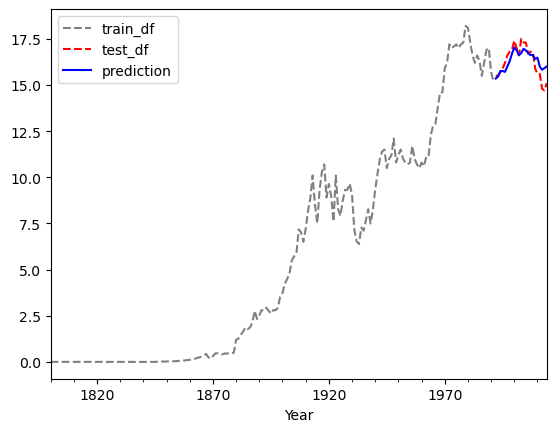

In [25]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['CO2'].plot(style='--', color='r', legend=True, label='test_df')
double_exp_test_pred.plot(color='b', legend=True, label='prediction')

In [26]:
print('Train RMSE:',mean_squared_error(train_df, double_exp_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df, double_exp_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df, double_exp_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df, double_exp_test_pred))

Train RMSE: 0.5219963052137858
Test RMSE: 0.535271644300464
Train MAPE: 12.806776199595548
Test MAPE: 0.026063828894697744


# ARIMA

In [27]:
ar = ARIMA(train_df, order=(15,1,15)).fit()
ar_train_pred = ar.fittedvalues
ar_test_pred = ar.forecast(23)

c:\Users\PRODI-TIF\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


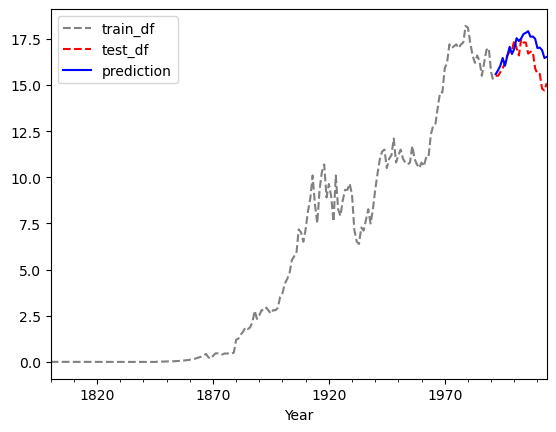

In [28]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['CO2'].plot(style='--', color='r', legend=True, label='test_df')
ar_test_pred.plot(color='b', legend=True, label='prediction')
plt.show()

In [29]:
print('Train RMSE:',mean_squared_error(train_df, ar_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df, ar_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df, ar_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df, ar_test_pred))

Train RMSE: 0.46777753233724584
Test RMSE: 0.9587457563109171
Train MAPE: 0.0814570749749771
Test MAPE: 0.04752754784573695


In [30]:
double_exp = ExponentialSmoothing(df, trend=None, initialization_method='heuristic', seasonal='add', seasonal_periods=29, damped_trend=False).fit()
double_exp_pred = double_exp.forecast(20)

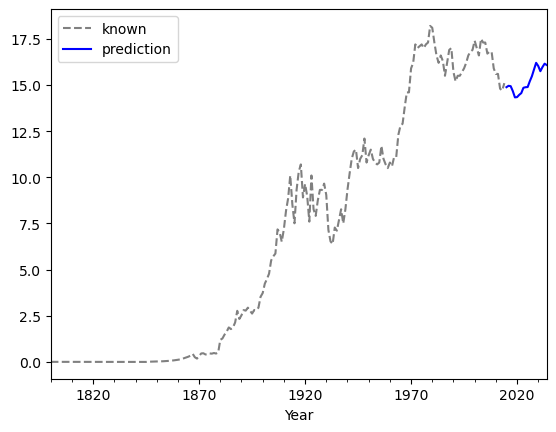

In [31]:
df['CO2'].plot(style='--', color='gray', legend=True, label='known')
double_exp_pred.plot(color='b', legend=True, label='prediction')
plt.show()

In [32]:
print('Train RMSE:',mean_squared_error(train_df, ar_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df, ar_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df, ar_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df, ar_test_pred))

Train RMSE: 0.46777753233724584
Test RMSE: 0.9587457563109171
Train MAPE: 0.0814570749749771
Test MAPE: 0.04752754784573695


# Perbandingan algoritma

In [33]:
comparision_df = pd.DataFrame(data=[
    ['Single exp smoothing', 1.3429 , 0.0686],
    ['double exp smoothing', 0.5352,  0.0260],
    ['ARIMA', 0.9591, 0.0475]
    ], 
    columns=['Model','RMSE','MAPE'])

comparision_df.set_index('Model', inplace=True)

In [34]:
comparision_df.sort_values(by='RMSE')

,RMSE,MAPE
Model,,
double exp smoothing,0.5352,0.0260
ARIMA,0.9591,0.0475
Single exp smoothing,1.3429,0.0686


In [35]:
import pickle

In [36]:
pickle.dump(double_exp, open('prediksi_udara.sav','wb'))